In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
import re
import time
import warnings
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
np.random.seed(10)


Using TensorFlow backend.


# Data Preprocessing

In [3]:
data = pd.read_csv('Training/training_variants')
print('number of data points : ', data.shape[0])
print('number of features : ', data.shape[1])
print('Features : ', data.columns.values)
data.head()

number of data points :  3321
number of features :  4
Features :  ['ID' 'Gene' 'Variation' 'Class']


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


The Data has 3321 Data points with 4 features

In [4]:
data_text = pd.read_csv('Training/training_text', sep='\|\|', engine= 'python', names=['ID', 'TEXT'], skiprows = 1)
print('Number of data points : ', data_text.shape[0])
print('Number of features : ', data_text.shape[1])
print('Features : ', data_text.columns.values)
data_text.head()

Number of data points :  3321
Number of features :  2
Features :  ['ID' 'TEXT']


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [5]:
import re
from nltk.corpus import stopwords

In [6]:
stop_words = set(stopwords.words("english"))

def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:                  #Checks if its a int or not
        string = ""
        #replace every special character with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        #replace with multiple spaces with single space
        total_text = re.sub('\s+', ' ', total_text)
        #convert all char to lower case
        total_text = total_text.lower()
        
        for word in total_text.split():
            if not word in stop_words:
                string += word + " "
                
        data_text[column][index] = string

In [7]:
import time

In [8]:
start_time = time.clock()
for index, row in data_text.iterrows():
    if type(row["TEXT"]) is str:
        nlp_preprocessing(row['TEXT'], index, 'TEXT')
    else:
        print("there is no description for id :", index)
print(time.clock() - start_time, "seconds")

there is no description for id : 1109
there is no description for id : 1277
there is no description for id : 1407
there is no description for id : 1639
there is no description for id : 2755
79.5487912 seconds


In [9]:
result = pd.merge(data, data_text, on="ID", how="left")
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [10]:
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [11]:
result.loc[result['TEXT'].isnull(), 'TEXT'] = result['Gene'] + result['Variation']

In [12]:
result[result['ID']==1109]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,FANCAS1088F


# Dividing the dataset into testing and training sets and cross validation

In [13]:
y_true = result['Class'].values

#replacing spaces between the words in Gene column with '_'
result.Gene = result.Gene.str.replace('\s+', '_')

#replacing spaces between the words in Variation column with '_'
result.Variation = result.Variation.str.replace('\s+', '_')

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
#splitting into train test
X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify = y_true, test_size=0.2)

#splitting train into train and cross validation
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [16]:
print(train_df.shape[0]) #data points in train set
print(test_df.shape[0])  #data points in test set
print(cv_df.shape[0])    #data points in cross validation set

2124
665
532


In [44]:
print(train_df.shape) #data points in train set
print(test_df.shape)  #data points in test set
print(cv_df.shape)    #data points in cross validation set

(2124, 5)
(665, 5)
(532, 5)


In [17]:
train_class_distribution = train_df['Class'].value_counts().sort_index()
test_class_distribution = test_df['Class'].value_counts().sort_index()
cv_class_distribution = cv_df['Class'].value_counts().sort_index()

In [18]:
print(train_class_distribution)

1    363
2    289
3     57
4    439
5    155
6    176
7    609
8     12
9     24
Name: Class, dtype: int64


In [19]:
print(test_class_distribution)

1    114
2     91
3     18
4    137
5     48
6     55
7    191
8      4
9      7
Name: Class, dtype: int64


In [20]:
print(cv_class_distribution)

1     91
2     72
3     14
4    110
5     39
6     44
7    153
8      3
9      6
Name: Class, dtype: int64


In [21]:
from matplotlib import style
style.use('fivethirtyeight') or plt.style.use('fivethirtyeight')

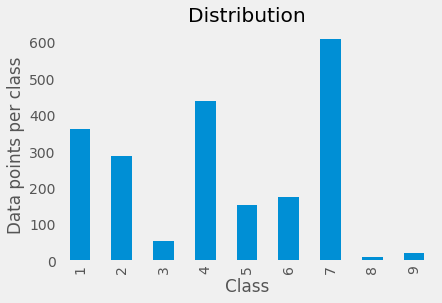

Number of data points in class 7 : 609 [ 28.67 %]
Number of data points in class 4 : 439 [ 20.67 %]
Number of data points in class 1 : 363 [ 17.09 %]
Number of data points in class 2 : 289 [ 13.61 %]
Number of data points in class 6 : 176 [ 8.29 %]
Number of data points in class 5 : 155 [ 7.3 %]
Number of data points in class 3 : 57 [ 2.68 %]
Number of data points in class 9 : 24 [ 1.13 %]
Number of data points in class 8 : 12 [ 0.56 %]


In [22]:
my_colors = 'rgbkmyc'
train_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per class')
plt.title('Distribution')
plt.grid()
plt.show()

sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':', train_class_distribution.values[i], '[', np.round((train_class_distribution.values[i]/train_df.shape[0]*100), 2), '%]' )

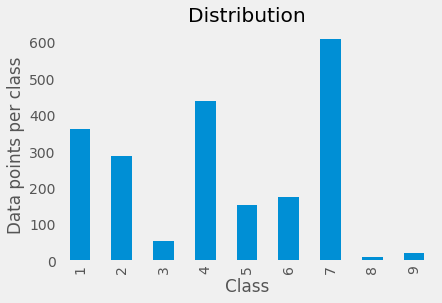

Number of data points in class 7 : 191 [ 28.72 %]
Number of data points in class 4 : 137 [ 20.6 %]
Number of data points in class 1 : 114 [ 17.14 %]
Number of data points in class 2 : 91 [ 13.68 %]
Number of data points in class 6 : 55 [ 8.27 %]
Number of data points in class 5 : 48 [ 7.22 %]
Number of data points in class 3 : 18 [ 2.71 %]
Number of data points in class 9 : 7 [ 1.05 %]
Number of data points in class 8 : 4 [ 0.6 %]


In [23]:
my_colors = 'rgbkmyc'
train_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per class')
plt.title('Distribution')
plt.grid()
plt.show()

sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':', test_class_distribution.values[i], '[', np.round((test_class_distribution.values[i]/test_df.shape[0]*100), 2), '%]' )

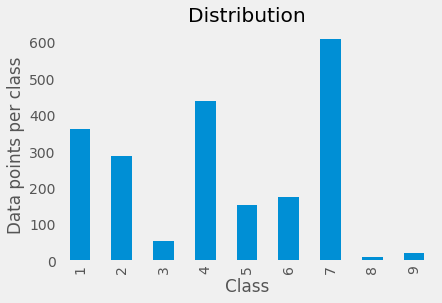

Number of data points in class 7 : 153 [ 28.76 %]
Number of data points in class 4 : 110 [ 20.68 %]
Number of data points in class 1 : 91 [ 17.11 %]
Number of data points in class 2 : 72 [ 13.53 %]
Number of data points in class 6 : 44 [ 8.27 %]
Number of data points in class 5 : 39 [ 7.33 %]
Number of data points in class 3 : 14 [ 2.63 %]
Number of data points in class 9 : 6 [ 1.13 %]
Number of data points in class 8 : 3 [ 0.56 %]


In [24]:
my_colors = 'rgbkmyc'
train_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per class')
plt.title('Distribution')
plt.grid()
plt.show()

sorted_yi = np.argsort(-cv_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':', cv_class_distribution.values[i], '[', np.round((cv_class_distribution.values[i]/cv_df.shape[0]*100), 2), '%]' )

# Prediction using a random model

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    #divide each element of the confusion matrix with the sum of elements in that column
    A = (((C.T)/(C.sum(axis=1))).T)
    
    #divide each element of the confusion matrix with the sum of elements in that row
    B = ((C/C.sum(axis=0)))
    labels = [1,2,3,4,5,6,7,8,9]
    
    print("-"*30, "Confusion matrix", "-"*30)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    print("-"*30, "Precision matrix (Columm Sum=1)", "-"*30)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    print("-"*30, "Recall matrix (Row sum=1)", "-"*30)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    

In [26]:
print(test_df.shape[0])
print(cv_df.shape[0])

665
532


In [27]:
from sklearn.metrics.classification import accuracy_score, log_loss

Log loss on Cross Validation Data using Random Model 2.498107350762019
Log loss on test Data using Random Model 2.498107350762019
------------------------------ Confusion matrix ------------------------------


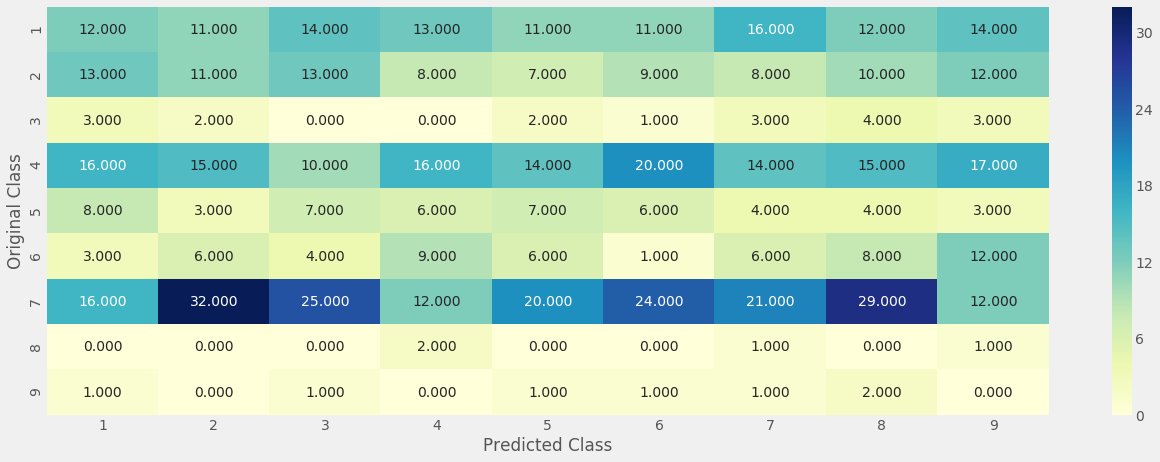

------------------------------ Precision matrix (Columm Sum=1) ------------------------------


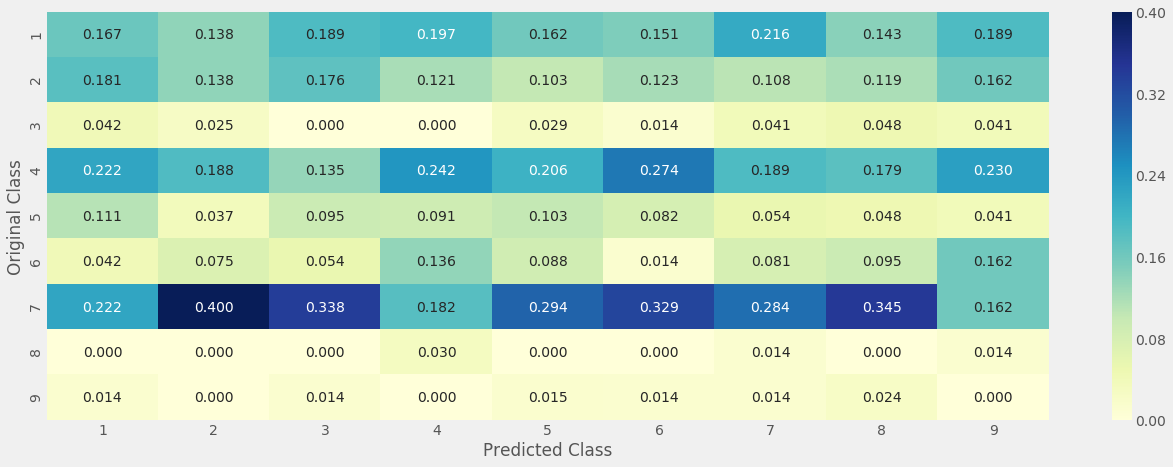

------------------------------ Recall matrix (Row sum=1) ------------------------------


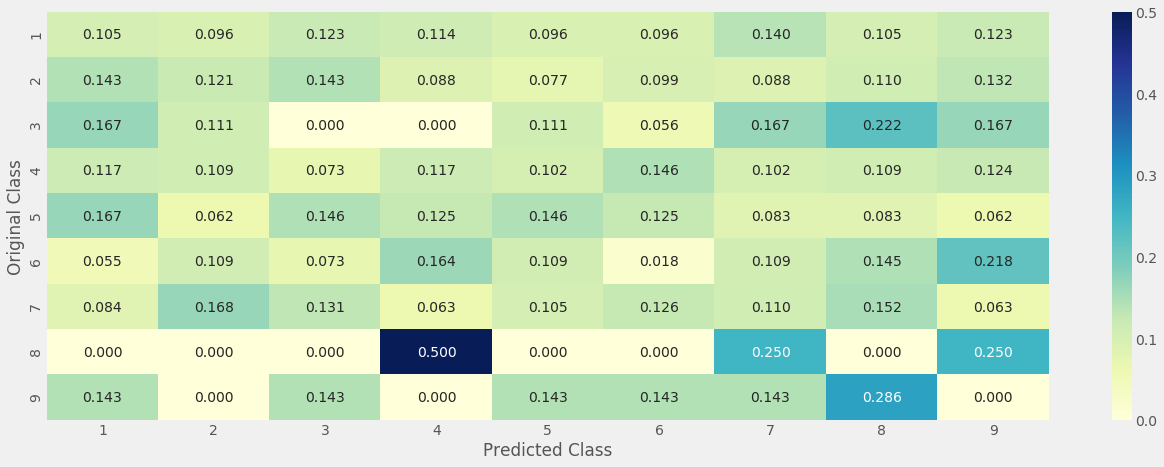

In [28]:
test_data_len = test_df.shape[0]
cv_data_len = cv_df.shape[0]

cv_predicted_y = np.zeros((cv_data_len,9))
for i in range(cv_data_len):
    rand_probs= np.random.rand(1,9)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv,cv_predicted_y, eps=1e-15))

#test set error
test_predicted_y = np.zeros((test_data_len, 9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on test Data using Random Model",log_loss(y_cv,cv_predicted_y, eps=1e-15))

predicted_y = np.argmax(test_predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y+1)

In [29]:
def get_gv_fea_dict(alpha, feature, df):
    value_count = train_df[feature].value_counts()  #Gives the count of eacg gene and variation in the dataframe
     
    gv_dict = dict()   #this dict will contain 9 probabilities of each gene variation of 9 classes
    
    for i, denominator in value_count.items():
        vec = []    #9 dimensional list containing 9 probabilities of each class for the ith gene
        for k in range(1,10):      #9 classes in total, count starts from 1-9
            cls_cnt = train_df.loc[(train_df['Class']==k) & (train_df[feature]==i)]
                                            #cls_cnt Displays all the class and variation o fthat specigic gene
            vec.append((cls_cnt.shape[0] + alpha*10) / (denominator + 90*alpha))
            
        gv_dict[i] = vec
        
    return gv_dict


def get_gv_feature(alpha, feature, df):
    
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    value_count = train_df[feature].value_counts()
    
    gv_fea = []          # for every feature values in the given data frame we will check if it is there in the train data then we will add the feature to gv_fea
                         # if not we will add [1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9] to gv_fea
        
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
    return gv_fea   

In [30]:
unique_genes = train_df['Gene'].value_counts()
print('Number of Unique Genes :', unique_genes.shape[0])
# the top 10 genes that occured most
print(unique_genes.head(10))

Number of Unique Genes : 229
BRCA1     165
TP53      107
EGFR       82
PTEN       73
BRCA2      73
KIT        65
BRAF       58
ERBB2      47
ALK        45
PDGFRA     40
Name: Gene, dtype: int64


In [105]:
unique_genes = test_df['Gene'].value_counts()
print('Number of Unique Genes :', unique_genes.shape[0])
# the top 10 genes that occured most
print(unique_genes.head(10))

Number of Unique Genes : 158
BRCA1     46
PTEN      37
BRCA2     33
TP53      33
EGFR      32
KIT       18
ALK       14
BRAF      14
ERBB2     13
PDGFRA    12
Name: Gene, dtype: int64


In [106]:
unique_genes = cv_df['Gene'].value_counts()
print('Number of Unique Genes :', unique_genes.shape[0])
# the top 10 genes that occured most
print(unique_genes.head(10))

Number of Unique Genes : 144
BRCA1    53
EGFR     27
TP53     23
BRAF     21
BRCA2    19
PTEN     16
KIT      16
FGFR2    15
VHL      11
ALK      10
Name: Gene, dtype: int64


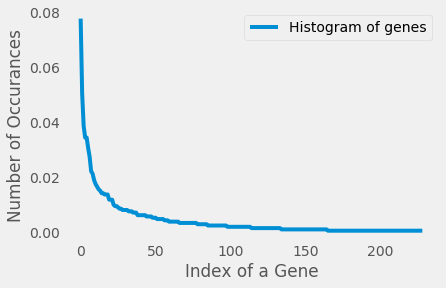

In [31]:
s = sum(unique_genes.values)
h = unique_genes.values/s
plt.plot(h, label='Histogram of genes')
plt.xlabel('Index of a Gene')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

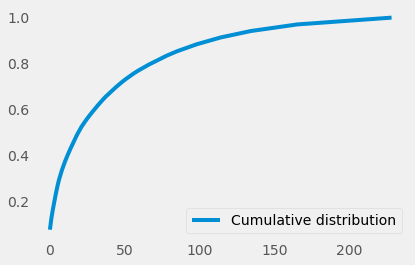

In [32]:
c = np.cumsum(h)
plt.plot(c, label='Cumulative distribution')
plt.grid()
plt.legend()
plt.show()

# Featurizing Gene Feature

In [33]:
#response coding for the Gene feature

alpha = 1    #Used for laplace smoothing
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", train_df))  #train gene feature
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", test_df))    #test gene feature
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", cv_df))      #cv gene feature

In [119]:
#one-hot encoding of Gene Feature
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

In [120]:
train_gene_feature_responseCoding.shape

(2124, 9)

In [121]:
test_gene_feature_responseCoding.shape

(665, 9)

In [122]:
cv_gene_feature_responseCoding.shape

(532, 9)

In [123]:
train_gene_feature_onehotCoding.shape

(2124, 228)

In [124]:
test_gene_feature_onehotCoding.shape

(665, 228)

In [125]:
cv_gene_feature_onehotCoding.shape

(532, 228)

In [107]:
gene_vectorizer.get_feature_names()

['abl1',
 'akt1',
 'akt2',
 'akt3',
 'alk',
 'apc',
 'ar',
 'araf',
 'arid1a',
 'atr',
 'aurka',
 'b2m',
 'bap1',
 'bcor',
 'braf',
 'brca1',
 'brca2',
 'casp8',
 'cbl',
 'ccnd3',
 'cdh1',
 'cdk12',
 'cdkn1b',
 'cdkn2a',
 'cebpa',
 'chek2',
 'crebbp',
 'ctcf',
 'ctnnb1',
 'ddr2',
 'dnmt3b',
 'egfr',
 'eif1ax',
 'ep300',
 'epas1',
 'epcam',
 'erbb2',
 'erbb4',
 'ercc2',
 'ercc3',
 'ercc4',
 'errfi1',
 'esr1',
 'etv1',
 'ewsr1',
 'ezh2',
 'fancc',
 'fbxw7',
 'fgf3',
 'fgfr1',
 'fgfr2',
 'fgfr3',
 'fgfr4',
 'flt3',
 'foxl2',
 'foxp1',
 'gata3',
 'h3f3a',
 'hras',
 'idh1',
 'ikzf1',
 'jak1',
 'jak2',
 'kdm5c',
 'kdr',
 'keap1',
 'kit',
 'kmt2a',
 'kmt2d',
 'kras',
 'lats1',
 'map2k1',
 'map2k2',
 'map2k4',
 'map3k1',
 'met',
 'mlh1',
 'msh2',
 'msh6',
 'mtor',
 'myc',
 'nf1',
 'nf2',
 'nfe2l2',
 'nfkbia',
 'nkx2',
 'notch1',
 'notch2',
 'nras',
 'nsd1',
 'ntrk1',
 'ntrk2',
 'ntrk3',
 'pbrm1',
 'pdgfra',
 'pdgfrb',
 'pik3ca',
 'pik3cb',
 'pik3r1',
 'pik3r2',
 'pms2',
 'pole',
 'ppp2r1a',
 '

# Predicting Yi using only the Gene Feature(SGD classifier)

For values of alpha =  1e-05 The log loss is: 1.2062118653510177
For values of alpha =  0.0001 The log loss is: 1.1739197219085866
For values of alpha =  0.001 The log loss is: 1.2013815967128083
For values of alpha =  0.01 The log loss is: 1.3381117394500277
For values of alpha =  0.1 The log loss is: 1.4409339084583934
For values of alpha =  1 The log loss is: 1.4822819845563902


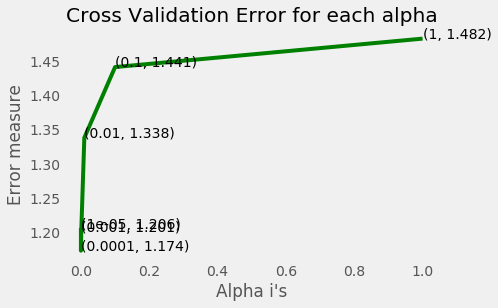

For values of best alpha =  0.0001 The train log loss is: 1.0230111985284778
For values of best alpha =  0.0001 The cross validation log loss is: 1.1739197219085866
For values of best alpha =  0.0001 The test log loss is: 1.1192668870518068


In [127]:
alpha = [10 ** x for x in range(-5,1)]  #hyperparameter for the SGD Classifier

cv_log_error_array = []
for i in alpha:
    clf = SGDClassifier(alpha = i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_gene_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
    sig_clf.fit(train_gene_feature_onehotCoding, y_train)
    
    predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, 'The log loss is:', log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array, c='g')
for i, txt in enumerate(np.round(cv_log_error_array, 3)):
    ax.annotate((alpha[i], np.round(txt,3)), (alpha[i], cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_gene_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
sig_clf.fit(train_gene_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

In [113]:
test_coverage=test_df[test_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]
cv_coverage=cv_df[cv_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]

print('Ans\n1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

Ans
1. In test data 644 out of 665 : 96.84210526315789
2. In cross validation data 515 out of  532 : 96.80451127819549


# Univariate Analysis on Variation Feature

In [114]:
unique_variations = train_df['Variation'].value_counts()
print(unique_variations.shape[0])
print(unique_variations.head())

1927
Truncating_Mutations    57
Deletion                49
Amplification           45
Fusions                 25
Overexpression           5
Name: Variation, dtype: int64


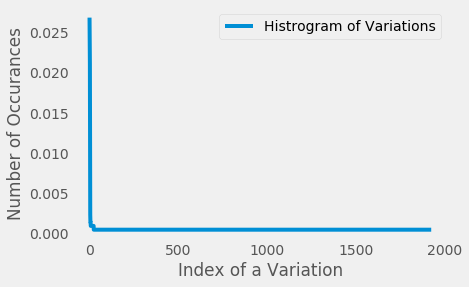

In [115]:
s = sum(unique_variations.values);
h = unique_variations.values/s;
plt.plot(h, label="Histrogram of Variations")
plt.xlabel('Index of a Variation')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

[0.02683616 0.04990584 0.07109228 ... 0.99905838 0.99952919 1.        ]


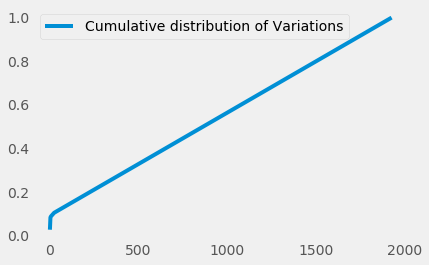

In [116]:
c = np.cumsum(h)
print(c)
plt.plot(c,label='Cumulative distribution of Variations')
plt.grid()
plt.legend()
plt.show()

In [128]:
alpha = 1
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", train_df))
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", test_df))
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", cv_df)) 

In [129]:
print(train_variation_feature_responseCoding.shape)
print(test_variation_feature_responseCoding.shape)
print(cv_variation_feature_responseCoding.shape)

(2124, 9)
(665, 9)
(532, 9)


In [131]:
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

In [133]:
print(train_variation_feature_onehotCoding.shape)
print(test_variation_feature_onehotCoding.shape)
print(cv_variation_feature_onehotCoding.shape)

(2124, 1957)
(665, 1957)
(532, 1957)


For values of alpha =  1e-05 The log loss is: 1.7156913533757971
For values of alpha =  0.0001 The log loss is: 1.7119376551133045
For values of alpha =  0.001 The log loss is: 1.7137985383393854
For values of alpha =  0.01 The log loss is: 1.7131136863228855
For values of alpha =  0.1 The log loss is: 1.7188340495004881
For values of alpha =  1 The log loss is: 1.7197838533700152


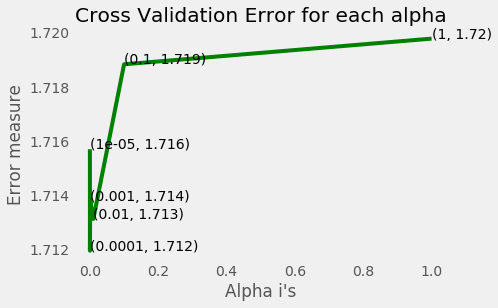

For values of best alpha =  0.0001 The train log loss is: 0.7447056535969796
For values of best alpha =  0.0001 The cross validation log loss is: 1.7119376551133045
For values of best alpha =  0.0001 The test log loss is: 1.7085904638312177


In [135]:
alpha = [10 ** x for x in range(-5, 1)]

cv_log_error_array = []
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_variation_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
    sig_clf.fit(train_variation_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
    
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_variation_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
 

In [136]:
def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] += 1
    return dictionary